Using device: cuda


100%|██████████| 9.91M/9.91M [00:00<00:00, 56.0MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.63MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 15.0MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 7.72MB/s]


Creating model: resnet10t, pretrained=False
Model (ResNet) has 4.93 M parameters, approx 18.80 MB.


     RUNNING SCENARIO: MetaFed_RL_G_ResTiny

--- Round 1/100 | FL: FedAvg | Orch: RlOrchestrator ---
   Orchestrator (RL-Explore): Selecting 10 clients randomly.
   Training client 16 (Compute: 0.74)...
   Training client 44 (Compute: 1.13)...
   Training client 31 (Compute: 0.97)...
   Training client 11 (Compute: 0.94)...
   Training client 20 (Compute: 1.18)...
   Training client 22 (Compute: 1.04)...
   Training client 13 (Compute: 1.14)...
   Training client 7 (Compute: 0.72)...
   Training client 2 (Compute: 0.93)...
   Training client 47 (Compute: 1.07)...
   Round 1 - Acc: 53.97% | CO2: 385.9g (Total: 385.9g) | Comm: 375.9MB | Time: 39.7s
   RL Reward: 37.905 (AccGain: 2.699 * 15, CO2Penalty: 2.573)

--- Round 2/100 | FL: FedAvg | Orch: RlOrchestrator ---
   Orchestrator (RL-Explore): Selecting 10 clients randomly.
   Training client 4 (Compute: 1.22)...
   Training client 11 (C

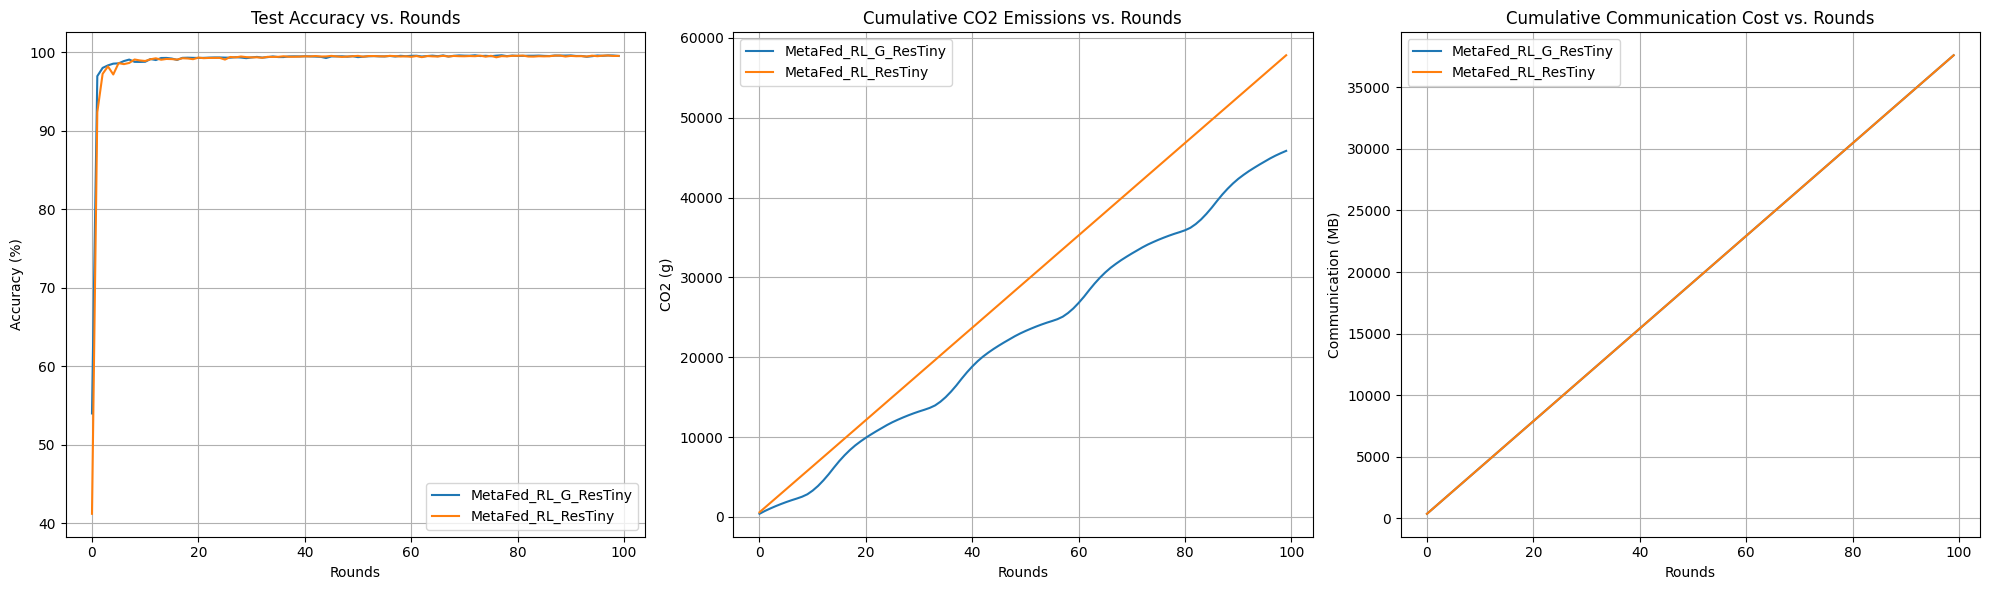


--- Final Results Summary (Last Round) ---
- MetaFed_RL_G_ResTiny: Acc = 99.53% | CO2 = 45846g | Comm = 37591MB
- MetaFed_RL_ResTiny  : Acc = 99.54% | CO2 = 57821g | Comm = 37591MB


In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
import copy
import pandas as pd
import time
import os
import timm # Import timm library

# --- General Settings ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

NUM_CLIENTS        = 50    # Total number of clients
CLIENTS_PER_ROUND  = 10    # Number of clients to select in each round (20%)
NUM_ROUNDS         = 100   # Number of rounds for meaningful convergence
LOCAL_EPOCHS       = 5     # Number of local training epochs (balance between 1-10)
BATCH_SIZE         = 32    # For memory and speed balance
LEARNING_RATE      = 1e-3  # Starting value compatible with AdamW + scheduler
NON_IID_ALPHA      = 0.5   # Moderate heterogeneity

# --- 1. Model: ResNet-10 Tiny (Adapted for MNIST) ---

def get_resnet_for_mnist(model_name='resnet10t', pretrained=False):
    """
    Creates a smaller ResNet model (e.g., ResNet-10 Tiny) for MNIST, either pre-trained or not.
    Uses the TIMM library to create the specified model and adapts the last layer for num_classes=10.
    Also adapts the first layer for a single input channel (MNIST).
    """
    print(f"Creating model: {model_name}, pretrained={pretrained}")
    try:
        model = timm.create_model(model_name, pretrained=pretrained, num_classes=10)
    except:
        print(f"Warning: {model_name} not found in timm. Falling back to resnet18.")
        model = timm.create_model('resnet18', pretrained=pretrained, num_classes=10)

    # Adapt the first convolutional layer for 1 input channel (MNIST is grayscale)
    # Most ResNet models expect 3 input channels.
    # Fix: Access the actual Conv2d layer if model.conv1 is a Sequential module
    if isinstance(model.conv1, nn.Sequential):
        # Assuming the Conv2d layer is the first element in the Sequential
        original_conv1 = model.conv1[0]
        model.conv1[0] = nn.Conv2d(1, original_conv1.out_channels,
                                    kernel_size=original_conv1.kernel_size,
                                    stride=original_conv1.stride,
                                    padding=original_conv1.padding,
                                    bias=original_conv1.bias)
    else: # If it's directly an nn.Conv2d
        model.conv1 = nn.Conv2d(1, model.conv1.out_channels,
                                kernel_size=model.conv1.kernel_size,
                                stride=model.conv1.stride,
                                padding=model.conv1.padding,
                                bias=model.conv1.bias)
    
    # Optional: Remove or replace MaxPool for smaller image sizes like MNIST (28x28)
    # ResNet's initial MaxPool might be too aggressive for 28x28 images.
    model.maxpool = nn.Identity() # Remove MaxPool or replace with Identity

    return model

# --- 2. Data Loading and Partitioning (Adapted for MNIST) ---

def get_mnist_data():
    """Loads the MNIST dataset."""
    transform_train = transforms.Compose([
        transforms.RandomCrop(28, padding=4), # MNIST image size is 28x28
        transforms.RandomRotation(10), # Random rotation can be useful for MNIST
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)), # Mean and std for MNIST dataset
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)), # Mean and std for MNIST dataset
    ])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
    return trainset, testset

def partition_data_non_iid(dataset, num_clients, alpha=0.5):
    """Partitions the dataset in a Non-IID manner using Dirichlet distribution."""
    targets = np.array(dataset.targets)
    num_classes = len(np.unique(targets))
    client_data_indices = [[] for _ in range(num_clients)]
    for k in range(num_classes):
        idx_k = np.where(targets == k)[0]
        np.random.shuffle(idx_k)
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        proportions = np.maximum(proportions, 1e-4) # Prevent very small proportions
        proportions = proportions / proportions.sum()
        proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
        splits = np.split(idx_k, proportions)
        for i, idx_j in enumerate(splits):
            client_data_indices[i].extend(idx_j.tolist())

    for indices in client_data_indices:
        random.shuffle(indices)

    return client_data_indices

def get_client_dataloaders(dataset, client_indices):
    """Creates a list of DataLoaders for each client."""
    return [DataLoader(Subset(dataset, indices), batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
            for indices in client_indices]

# --- 3. Green Computing Simulation (Updated) ---

CARBON_INTENSITY_DATA = pd.Series(
    [100, 90, 80, 75, 70, 65, 60, 55, 60, 80, 120, 150,
     180, 200, 220, 210, 190, 170, 150, 130, 120, 110, 105, 100] * 5 # 5 days
)
def get_carbon_intensity(current_round):
    return CARBON_INTENSITY_DATA[current_round % len(CARBON_INTENSITY_DATA)]

# NEW: Incorporate client capability into CO2 estimation
def estimate_energy_co2(compute_steps, carbon_intensity, model_size_mb, client_compute_capability=1.0):
    KWH_PER_STEP_GPU = 0.00005 # Base KWH/step
    MB_PER_KWH_COMM = 50        # Communication cost estimation

    # Scale computation energy with client capability (1.0 = baseline)
    energy_compute = compute_steps * KWH_PER_STEP_GPU * client_compute_capability
    energy_comm = model_size_mb / MB_PER_KWH_COMM
    total_energy = energy_compute + energy_comm
    co2_grams = total_energy * carbon_intensity
    comm_cost = model_size_mb # Assume only model size is transmitted
    return total_energy, co2_grams, comm_cost

# --- 4. Client and Server Classes (Minor Adjustments/Notes for FedProx and SCAFFOLD) ---

class Client:
    """Base Client Class."""
    def __init__(self, client_id, train_loader, model_template, lr, device):
        self.id = client_id
        self.loader = train_loader
        self.model = copy.deepcopy(model_template).to(device)
        self.lr = lr
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        # Simulated capabilities (Compute: 0.7 = slow/efficient, 1.3 = fast/powerful)
        self.capabilities = {'compute': random.uniform(0.7, 1.3), 'network': random.uniform(0.5, 1.5)}

    def train(self, global_model_state, epochs):
        """Basic training function (for FedAvg)."""
        self.model.load_state_dict(global_model_state)
        self.model.train()
        # AdamW usually gives better performance
        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr)
        steps = 0
        for _ in range(epochs):
            for images, labels in self.loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                steps += 1
        return self.model.state_dict(), len(self.loader.dataset), steps

class FedProxClient(Client):
    """FedProx Client."""
    def __init__(self, client_id, train_loader, model_template, lr, device, mu=0.01):
        super().__init__(client_id, train_loader, model_template, lr, device)
        self.mu = mu

    def train(self, global_model_state, epochs):
        global_model_ref = copy.deepcopy(self.model)
        global_model_ref.load_state_dict(global_model_state)
        global_model_ref.to(self.device)

        self.model.load_state_dict(global_model_state)
        self.model.train()
        optimizer = optim.AdamW(self.model.parameters(), lr=self.lr) # Use AdamW
        steps = 0

        for _ in range(epochs):
            for images, labels in self.loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                prox_term = 0.0
                for param, global_param in zip(self.model.parameters(), global_model_ref.parameters()):
                    prox_term += ((param - global_param) ** 2).sum()

                loss = loss + (self.mu / 2) * prox_term
                loss.backward()
                optimizer.step()
                steps += 1
        return self.model.state_dict(), len(self.loader.dataset), steps

class SCAFFOLDClient(Client):
    """SCAFFOLD Client."""
    def __init__(self, client_id, train_loader, model_template, lr, device):
        super().__init__(client_id, train_loader, model_template, lr, device)
        self.control_variate = {name: torch.zeros_like(param).to(device) for name, param in self.model.named_parameters()}
        self.server_control_variate = {name: torch.zeros_like(param).to(device) for name, param in self.model.named_parameters()}

    def train(self, global_model_state, epochs, server_cv):
        self.model.load_state_dict(global_model_state)
        # Copy server CV and send to device
        self.server_control_variate = {k: v.to(self.device) for k, v in server_cv.items()}
        self.model.train()
        optimizer = optim.SGD(self.model.parameters(), lr=self.lr) # SCAFFOLD typically uses SGD
        steps = 0
        initial_model_state = {k: v.clone().to(self.device) for k, v in self.model.state_dict().items()}
        new_cv = {k: v.clone().to(self.device) for k, v in self.control_variate.items()}

        K_total = 0 # Keep track of total steps
        for _ in range(epochs):
            for images, labels in self.loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()

                with torch.no_grad():
                    for name, param in self.model.named_parameters():
                        if param.grad is not None:
                            # Ensure control variates are moved to device
                            param.grad += self.server_control_variate[name] - self.control_variate[name]
                optimizer.step()
                steps += 1
                K_total += 1 # Count each step

        # NOTE: SCAFFOLD getting stuck at 10% accuracy usually comes from learning rate (lr)
        # or nuances in control variate updates.
        # Using K as the total number of steps might be more stable.
        if K_total == 0: K_total = 1 # Prevent division by zero

        with torch.no_grad():
            K = K_total # Use total steps
            lr_k = K * self.lr
            for name, param in self.model.named_parameters():
                # c_i^+ = c_i - c + (x - y_i) / (K * lr)
                new_cv[name] = self.control_variate[name] - self.server_control_variate[name] + \
                               (initial_model_state[name] - param) / lr_k

        delta_y = {name: self.model.state_dict()[name] - initial_model_state[name] for name in self.model.state_dict()}
        delta_c = {name: new_cv[name] - self.control_variate[name] for name in new_cv}
        self.control_variate = new_cv

        return delta_y, delta_c, len(self.loader.dataset), steps

class Server:
    """Base FL Server."""
    def __init__(self, model_template, test_loader, clients, device):
        self.model = copy.deepcopy(model_template).to(device)
        self.test_loader = test_loader
        self.clients = clients
        self.device = device

    def aggregate(self, updates, weights):
        """FedAvg aggregation."""
        total_weight = sum(weights)
        global_state = self.model.state_dict()
        for key in global_state:
            # Important: We assume tensors in 'updates' are already on the correct client device.
            # You need to move them to self.device when aggregating.
            global_state[key] = torch.stack([up[key].float().to(self.device) * w for up, w in zip(updates, weights)], 0).sum(0) / total_weight
        self.model.load_state_dict(global_state)
        return global_state

    def evaluate(self):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return 100 * correct / total

class SCAFFOLDServer(Server):
    """SCAFFOLD Server."""
    def __init__(self, model_template, test_loader, clients, device, lr_global=1.0):
        super().__init__(model_template, test_loader, clients, device)
        self.control_variate = {name: torch.zeros_like(param).to(device) for name, param in self.model.named_parameters()}
        self.lr_global = lr_global

    def aggregate(self, delta_ys, delta_cs, weights):
        total_weight = sum(weights)
        # Move to device when calculating average delta_y and delta_c
        avg_delta_y = {name: torch.zeros_like(param).to(self.device) for name, param in self.model.named_parameters()}
        avg_delta_c = {name: torch.zeros_like(param).to(self.device) for name, param in self.model.named_parameters()}

        for key in avg_delta_y:
            avg_delta_y[key] = torch.stack([dy[key].float().to(self.device) * w for dy, w in zip(delta_ys, weights)], 0).sum(0) / total_weight
            avg_delta_c[key] = torch.stack([dc[key].float().to(self.device) * w for dc, w in zip(delta_cs, weights)], 0).sum(0) / total_weight

        with torch.no_grad():
            for name, param in self.model.named_parameters():
                param += self.lr_global * avg_delta_y[name]

        with torch.no_grad():
            for name in self.control_variate:
                self.control_variate[name] += (len(weights) / NUM_CLIENTS) * avg_delta_c[name]

        return self.model.state_dict()


# --- 5. Orchestrators (Updated) ---

class RandomOrchestrator:
    """Random Client Selection (Baseline)."""
    def select_clients(self, all_clients, num_to_select, current_round):
        print(f"   Orchestrator (Random): Selecting {num_to_select} clients.")
        return random.sample(range(len(all_clients)), num_to_select)

class RlOrchestrator:
    """
    Improved Q-Learning Orchestrator (MetaFed-Vision Simulation).
    """
    # UPDATED: Epsilon decay increased
    def __init__(self, num_clients, num_actions, green_aware=True, lr=0.1, gamma=0.9, epsilon=1.0, min_epsilon=0.05, decay=0.98): # Decay from 0.99 to 0.98
        self.num_clients = num_clients
        self.num_actions = num_actions
        self.green_aware = green_aware
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = decay
        self.q_table = {} # {state: {client_id: q_value}}

    # UPDATED: State simplified
    def get_state(self, carbon_intensity, acc_history, client_capabilities):
        carbon_level = "low" if carbon_intensity < 100 else ("medium" if carbon_intensity < 200 else "high")
        acc_trend = "up" if len(acc_history) < 2 or acc_history[-1] > acc_history[-2] else "down"
        # Removed high_compute_count
        return (carbon_level, acc_trend)

    # UPDATED: Selection mechanism (bias added)
    def choose_clients(self, state, all_clients, num_to_select, client_capabilities, carbon_intensity):
        if random.uniform(0, 1) < self.epsilon:
            print(f"   Orchestrator (RL-Explore): Selecting {num_to_select} clients randomly.")
            return random.sample(range(len(all_clients)), num_to_select), None # No Q_values for exploration
        else:
            q_values_for_state = self.q_table.get(state, {i: 0 for i in range(len(all_clients))})
            adjusted_q = {}
            for i in range(len(all_clients)):
                base_q = q_values_for_state.get(i, 0)
                if self.green_aware:
                    compute_cap = client_capabilities[i]['compute']
                    carbon_scale = carbon_intensity / 150.0 # Scale assuming average is 150
                    # Slightly penalize high power in high carbon (weight=0.05)
                    bias = (compute_cap - 1.0) * carbon_scale * 0.05
                    adjusted_q[i] = base_q - bias
                else:
                    adjusted_q[i] = base_q

            sorted_clients = sorted(adjusted_q.keys(), key=lambda i: adjusted_q[i], reverse=True)
            print(f"   Orchestrator (RL-Exploit): Selecting {num_to_select} clients based on Q-values + Bias.")
            return sorted_clients[:num_to_select], adjusted_q

    def update_q_table(self, state, selected_indices, reward, next_state):
        if state is None or not selected_indices: return # Do not update during exploration or on error

        next_q_values = self.q_table.get(next_state, {})
        next_max_q = max(next_q_values.values()) if next_q_values else 0

        for client_id in selected_indices:
            old_value = self.q_table.get(state, {}).get(client_id, 0)
            new_value = (1 - self.lr) * old_value + self.lr * (reward + self.gamma * next_max_q)
            if state not in self.q_table:
                self.q_table[state] = {i: 0 for i in range(self.num_clients)}
            self.q_table[state][client_id] = new_value

        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay


# --- 6. Simulation Core (Updated) ---

def run_simulation_core(fl_algorithm, orchestrator, clients, server, num_rounds, clients_per_round, use_green, model_param_size_mb):
    accuracies = []
    total_co2_list = []
    total_comm_list = []
    total_co2 = 0
    total_comm = 0
    rl_agent = orchestrator if isinstance(orchestrator, RlOrchestrator) else None
    last_state = None

    for r in range(num_rounds):
        start_time = time.time()
        print(f"\n--- Round {r + 1}/{num_rounds} | FL: {fl_algorithm} | Orch: {type(orchestrator).__name__} ---")

        carbon_now = get_carbon_intensity(r) if use_green else 150

        # A) Client Selection
        client_capabilities = [c.capabilities for c in clients] # Get capabilities
        if rl_agent:
            state = rl_agent.get_state(carbon_now, accuracies, client_capabilities)
            selected_indices, q_values = rl_agent.choose_clients(state, clients, clients_per_round, client_capabilities, carbon_now)
            last_state = state # Store for Q-update
        else:
            selected_indices = orchestrator.select_clients(clients, clients_per_round, r)

        selected_clients = [clients[i] for i in selected_indices]

        # B) Local Training and Collection
        updates = []
        delta_cs = [] # For SCAFFOLD
        weights = []
        round_co2 = 0
        round_comm = 0

        global_state = server.model.state_dict()
        server_cv = getattr(server, 'control_variate', None) # For SCAFFOLD

        for client in selected_clients:
            print(f"   Training client {client.id} (Compute: {client.capabilities['compute']:.2f})...")
            if fl_algorithm == 'SCAFFOLD':
                delta_y, delta_c, weight, steps = client.train(global_state, LOCAL_EPOCHS, server_cv)
                updates.append(delta_y)
                delta_cs.append(delta_c)
            else: # FedAvg, FedProx
                update, weight, steps = client.train(global_state, LOCAL_EPOCHS)
                updates.append(update)

            weights.append(weight)
            # UPDATED: estimate_energy_co2 call
            _, co2, comm = estimate_energy_co2(steps, carbon_now, model_param_size_mb, client.capabilities['compute'])
            round_co2 += co2
            round_comm += comm * 2 # Both download and upload

        total_co2 += round_co2
        total_comm += round_comm

        # C) Global Aggregation
        if fl_algorithm == 'SCAFFOLD':
            server.aggregate(updates, delta_cs, weights)
        else: # FedAvg, FedProx
            server.aggregate(updates, weights)

        # D) Evaluation
        accuracy = server.evaluate()
        accuracies.append(accuracy)
        total_co2_list.append(total_co2)
        total_comm_list.append(total_comm)
        end_time = time.time()
        round_duration = end_time - start_time
        print(f"   Round {r + 1} - Acc: {accuracy:.2f}% | CO2: {round_co2:.1f}g (Total: {total_co2:.1f}g) | Comm: {round_comm:.1f}MB | Time: {round_duration:.1f}s")

        # E) RL Update
        if rl_agent:
            # UPDATED: Reward function
            acc_gain = (accuracies[-1] - accuracies[-2]) if len(accuracies) > 1 else accuracies[-1] * 0.05 # Small reward for first round
            # Penalize CO2 more strongly, reward Acc gain more strongly
            co2_penalty = (round_co2 / 150) # Instead of previous 100/200, use 150 as average
            reward = acc_gain * 15 - co2_penalty # Increase weight of Acc gain (10->15), adjust CO2 penalty
            print(f"   RL Reward: {reward:.3f} (AccGain: {acc_gain:.3f} * 15, CO2Penalty: {co2_penalty:.3f})")

            next_carbon = get_carbon_intensity(r + 1) if use_green else 150
            next_state = rl_agent.get_state(next_carbon, accuracies, client_capabilities)
            rl_agent.update_q_table(last_state, selected_indices, reward, next_state)


    return accuracies, total_co2_list, total_comm_list

# --- 7. Main Simulation Manager (No changes) ---

def main():
    trainset, testset = get_mnist_data() # Changed to MNIST data
    test_loader = DataLoader(testset, batch_size=BATCH_SIZE * 2, shuffle=False)
    client_indices = partition_data_non_iid(trainset, NUM_CLIENTS, NON_IID_ALPHA)

    model_template = get_resnet_for_mnist(model_name='resnet10t') # Changed to MNIST model adaptation

    num_params = sum(p.numel() for p in model_template.parameters() if p.requires_grad)
    model_param_size_mb = num_params * 4 / (1024 * 1024)
    print(f"Model ({model_template.__class__.__name__}) has {num_params / 1e6:.2f} M parameters, approx {model_param_size_mb:.2f} MB.")


    scenarios = {

        "MetaFed_RL_G_ResTiny": {'algo': 'FedAvg',   'orch': 'RL',     'green': True},  # Our proposal (Improved)
        "MetaFed_RL_ResTiny":   {'algo': 'FedAvg',   'orch': 'RL',     'green': False}, # Ablation: RL present, Green absent

    }

    results = {}

    for name, config in scenarios.items():
        print(f"\n\n=======================================")
        print(f"     RUNNING SCENARIO: {name}")
        print(f"=======================================")

        # Create clients (fresh start for each scenario)
        clients = []
        for i in range(NUM_CLIENTS):
            loader = DataLoader(Subset(trainset, client_indices[i]), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
            if config['algo'] == 'FedProx':
                clients.append(FedProxClient(i, loader, model_template, LEARNING_RATE, DEVICE))
            elif config['algo'] == 'SCAFFOLD':
                clients.append(SCAFFOLDClient(i, loader, model_template, LEARNING_RATE, DEVICE))
            else: # FedAvg
                clients.append(Client(i, loader, model_template, LEARNING_RATE, DEVICE))

        # Create server
        if config['algo'] == 'SCAFFOLD':
            server = SCAFFOLDServer(model_template, test_loader, clients, DEVICE)
        else:
            server = Server(model_template, test_loader, clients, DEVICE)

        # Create orchestrator
        if config['orch'] == 'RL':
            # Create a new agent for each RL scenario
            orchestrator = RlOrchestrator(NUM_CLIENTS, CLIENTS_PER_ROUND, green_aware=config['green'])
        else:
            orchestrator = RandomOrchestrator()

        # Run simulation
        acc, co2, comm = run_simulation_core(
            config['algo'], orchestrator, clients, server, NUM_ROUNDS, CLIENTS_PER_ROUND, config['green'], model_param_size_mb
        )
        results[name] = {'accuracy': acc, 'co2': co2, 'comm': comm}

        if isinstance(orchestrator, RlOrchestrator):
            print(f"RL Q-Table size for {name}: {len(orchestrator.q_table)}")


    # --- 8. Visualize and Save Results ---
    try:
        import matplotlib.pyplot as plt

        fig, axes = plt.subplots(1, 3, figsize=(20, 6))

        # Accuracy
        ax = axes[0]
        for name, data in results.items():
            ax.plot(data['accuracy'], label=f'{name}')
        ax.set_title('Test Accuracy vs. Rounds')
        ax.set_xlabel('Rounds')
        ax.set_ylabel('Accuracy (%)')
        ax.legend()
        ax.grid(True)

        # CO2 Emissions
        ax = axes[1]
        for name, data in results.items():
            ax.plot(data['co2'], label=f'{name}')
        ax.set_title('Cumulative CO2 Emissions vs. Rounds')
        ax.set_xlabel('Rounds')
        ax.set_ylabel('CO2 (g)')
        ax.legend()
        ax.grid(True)

        # Communication Cost
        ax = axes[2]
        for name, data in results.items():
            ax.plot(data['comm'], label=f'{name}')
        ax.set_title('Cumulative Communication Cost vs. Rounds')
        ax.set_xlabel('Rounds')
        ax.set_ylabel('Communication (MB)')
        ax.legend()
        ax.grid(True)

        plt.tight_layout()
        plt.savefig("metafed_mnist_detailed_results_restiny_improved.png") # Changed filename for MNIST
        print("\nResults plot saved as 'metafed_mnist_detailed_results_restiny_improved.png'")
        plt.show()

    except ImportError:
        print("\nMatplotlib not found. Please install it: pip install matplotlib")

    print("\n--- Final Results Summary (Last Round) ---")
    for name, data in results.items():
        print(f"- {name:<20}: Acc = {data['accuracy'][-1]:.2f}% | CO2 = {data['co2'][-1]:.0f}g | Comm = {data['comm'][-1]:.0f}MB")

if __name__ == "__main__":
    main()

In [ ]:
llff

Using device: cuda
Creating model: resnet10t, pretrained=False
Model (ResNet) has 4.93 M parameters, approx 18.80 MB.


     RUNNING SCENARIO: FedAvg_ResTiny

--- Round 1/100 | FL: FedAvg | Orch: RandomOrchestrator ---
   Orchestrator (Random): Selecting 10 clients.
   Training client 0 (Compute: 1.03)...
   Training client 40 (Compute: 1.11)...
   Training client 16 (Compute: 0.74)...
   Training client 44 (Compute: 1.13)...
   Training client 31 (Compute: 0.97)...
   Training client 11 (Compute: 0.94)...
   Training client 20 (Compute: 1.18)...
   Training client 22 (Compute: 1.04)...
   Training client 13 (Compute: 1.14)...
   Training client 7 (Compute: 0.72)...
   Round 1 - Acc: 48.66% | CO2: 578.6g (Total: 578.6g) | Comm: 375.9MB | Time: 35.0s

--- Round 2/100 | FL: FedAvg | Orch: RandomOrchestrator ---
   Orchestrator (Random): Selecting 10 clients.
   Training client 44 (Compute: 1.13)...
   Training client 2 (Compute: 0.93)...
   Training client 31 (Compute: 0.97)...
   Traini

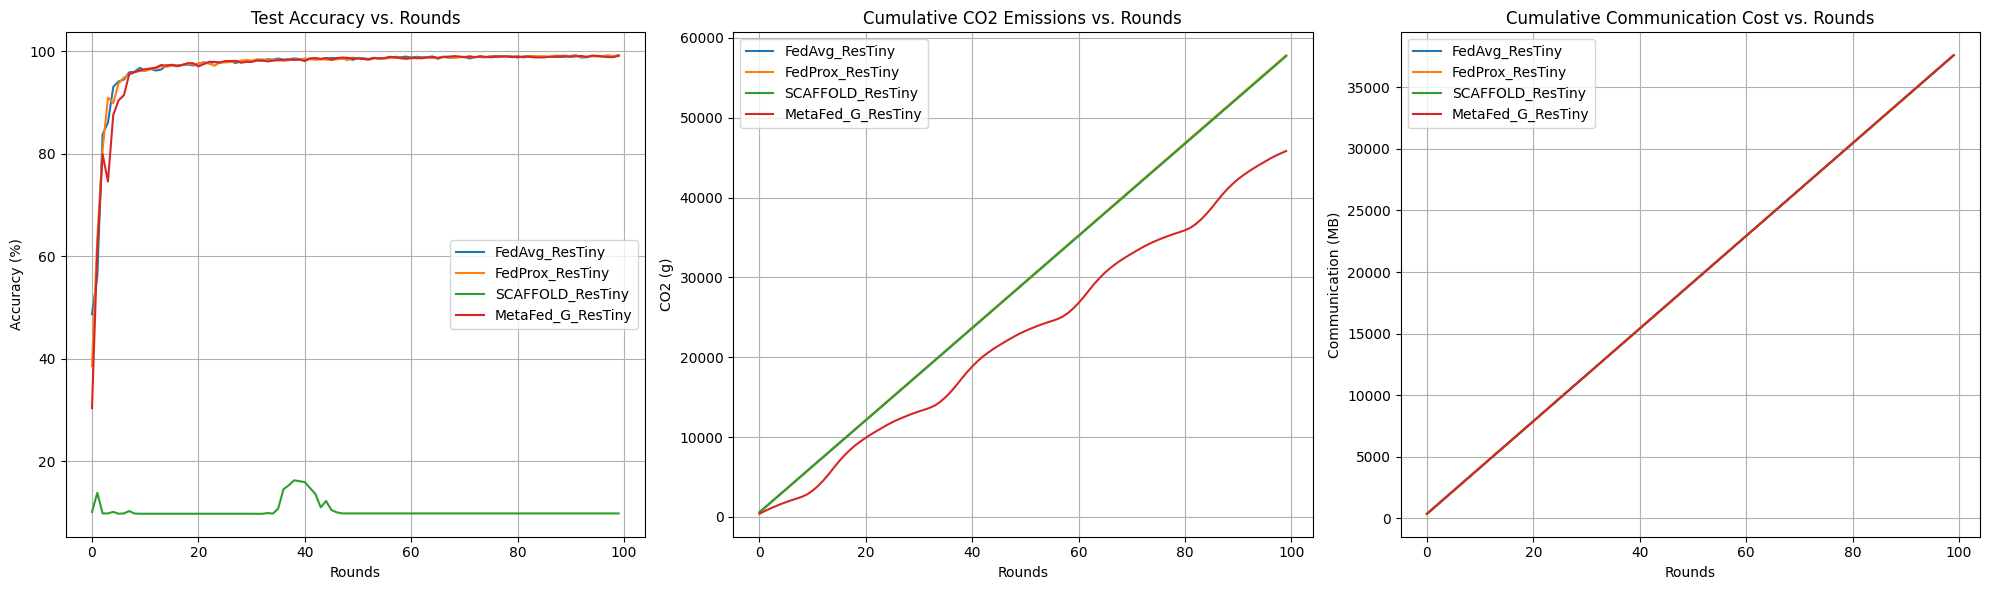


--- Final Results Summary (Last Round) ---
- FedAvg_ResTiny      : Acc = 99.19% | CO2 = 57755g | Comm = 37591MB
- FedProx_ResTiny     : Acc = 99.14% | CO2 = 57820g | Comm = 37591MB
- SCAFFOLD_ResTiny    : Acc = 9.80% | CO2 = 57719g | Comm = 37591MB
- MetaFed_G_ResTiny   : Acc = 99.09% | CO2 = 45826g | Comm = 37591MB


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
import copy
import pandas as pd
import time
import os
import timm # Import timm library

# --- General Settings ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

NUM_CLIENTS        = 50    # Total number of clients
CLIENTS_PER_ROUND  = 10    # Number of clients to select in each round (20%)
NUM_ROUNDS         = 100   # Number of rounds for meaningful convergence
LOCAL_EPOCHS       = 5     # Number of local training epochs (balance between 1-10)
BATCH_SIZE         = 32    # For memory and speed balance
LEARNING_RATE      = 1e-3  # Starting value compatible with AdamW + scheduler
NON_IID_ALPHA      = 0.5   # Moderate heterogeneity


# --- 1. Model: ResNet-10 Tiny (Adapted for MNIST) ---

def get_resnet_for_mnist(model_name='resnet10t', pretrained=False):
    """
    Creates a smaller ResNet model (e.g., ResNet-10 Tiny) for MNIST, either pre-trained or not.
    Uses the TIMM library to create the specified model and adapts the last layer for num_classes=10.
    Also adapts the first layer for a single input channel (MNIST).
    """
    print(f"Creating model: {model_name}, pretrained={pretrained}")
    try:
        model = timm.create_model(model_name, pretrained=pretrained, num_classes=10)
    except Exception as e:
        print(f"Warning: {model_name} not found in timm or error occurred ({e}). Falling back to resnet18.")
        model = timm.create_model('resnet18', pretrained=pretrained, num_classes=10)

    # Adapt the first convolutional layer for 1 input channel (MNIST is grayscale)
    # Most ResNet models expect 3 input channels.
    # We need to ensure we modify the actual Conv2d layer, even if it's wrapped in Sequential.
    if isinstance(model.conv1, nn.Sequential):
        # Assuming the Conv2d layer is the first element in the Sequential
        original_conv1 = model.conv1[0]
        model.conv1[0] = nn.Conv2d(1, original_conv1.out_channels,
                                    kernel_size=original_conv1.kernel_size,
                                    stride=original_conv1.stride,
                                    padding=original_conv1.padding,
                                    bias=original_conv1.bias)
    else: # If it's directly an nn.Conv2d
        model.conv1 = nn.Conv2d(1, model.conv1.out_channels,
                                kernel_size=model.conv1.kernel_size,
                                stride=model.conv1.stride,
                                padding=model.conv1.padding,
                                bias=model.conv1.bias)

    # Optional: Remove or replace MaxPool for smaller image sizes like MNIST (28x28)
    # ResNet's initial MaxPool might be too aggressive for 28x28 images.
    # Replacing it with Identity keeps the architecture but bypasses the pooling.
    model.maxpool = nn.Identity()

    return model

# --- 2. Data Loading and Partitioning (Adapted for MNIST) ---

def get_mnist_data():
    """Loads the MNIST dataset."""
    transform_train = transforms.Compose([
        transforms.RandomCrop(28, padding=4), # MNIST image size is 28x28
        transforms.RandomRotation(10), # Random rotation can be useful for MNIST
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)), # Mean and std for MNIST dataset (single channel)
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)), # Mean and std for MNIST dataset (single channel)
    ])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
    return trainset, testset

def partition_data_non_iid(dataset, num_clients, alpha=0.5):
    """Partitions the dataset in a Non-IID manner using Dirichlet distribution."""
    # MNIST dataset uses .targets directly
    targets = np.array(dataset.targets)
    num_classes = len(np.unique(targets))
    client_data_indices = [[] for _ in range(num_clients)]
    for k in range(num_classes):
        idx_k = np.where(targets == k)[0]
        np.random.shuffle(idx_k)
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        # Adjust to ensure each client gets at least a few samples
        proportions = np.maximum(proportions, 1e-4) # Prevent very small proportions
        proportions = proportions / proportions.sum()
        proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
        splits = np.split(idx_k, proportions)
        for i, idx_j in enumerate(splits):
            client_data_indices[i].extend(idx_j.tolist())

    # Shuffle for good measure
    for indices in client_data_indices:
        random.shuffle(indices)

    return client_data_indices

def get_client_dataloaders(dataset, client_indices):
    """Creates a list of DataLoaders for each client."""
    return [DataLoader(Subset(dataset, indices), batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
            for indices in client_indices]

# --- 3. Green Computing Simulation ---

CARBON_INTENSITY_DATA = pd.Series(
    [100, 90, 80, 75, 70, 65, 60, 55, 60, 80, 120, 150,
     180, 200, 220, 210, 190, 170, 150, 130, 120, 110, 105, 100] * 5 # 5 days
)
def get_carbon_intensity(current_round):
    return CARBON_INTENSITY_DATA[current_round % len(CARBON_INTENSITY_DATA)]

def estimate_energy_co2(compute_steps, carbon_intensity, model_size_mb, client_compute_capability=1.0):
    KWH_PER_STEP_GPU = 0.00005 # Base KWH/step
    MB_PER_KWH_COMM = 50        # Communication cost estimation

    # Scale computation energy with client capability (1.0 = baseline)
    energy_compute = compute_steps * KWH_PER_STEP_GPU * client_compute_capability
    energy_comm = model_size_mb / MB_PER_KWH_COMM
    total_energy = energy_compute + energy_comm
    co2_grams = total_energy * carbon_intensity
    comm_cost = model_size_mb # Assume only model size is transmitted
    return total_energy, co2_grams, comm_cost

# --- 4. Client and Server Classes (FL Algorithms) ---

class Client:
    """Base Client Class."""
    def __init__(self, client_id, train_loader, model_template, lr, device):
        self.id = client_id
        self.loader = train_loader
        self.model = copy.deepcopy(model_template).to(device)
        self.lr = lr
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        # Simulated capabilities (Compute: 0.7 = slow/efficient, 1.3 = fast/powerful)
        self.capabilities = {'compute': random.uniform(0.7, 1.3), 'network': random.uniform(0.5, 1.5)}

    def train(self, global_model_state, epochs):
        """Basic training function (for FedAvg)."""
        self.model.load_state_dict(global_model_state)
        self.model.train()
        optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
        steps = 0
        for _ in range(epochs):
            for images, labels in self.loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                steps += 1
        return self.model.state_dict(), len(self.loader.dataset), steps

class FedProxClient(Client):
    """FedProx Client."""
    def __init__(self, client_id, train_loader, model_template, lr, device, mu=0.01):
        super().__init__(client_id, train_loader, model_template, lr, device)
        self.mu = mu

    def train(self, global_model_state, epochs):
        global_model_ref = copy.deepcopy(self.model)
        global_model_ref.load_state_dict(global_model_state)
        global_model_ref.to(self.device)

        self.model.load_state_dict(global_model_state)
        self.model.train()
        optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
        steps = 0

        for _ in range(epochs):
            for images, labels in self.loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)

                # Proximal Term
                prox_term = 0.0
                for param, global_param in zip(self.model.parameters(), global_model_ref.parameters()):
                    prox_term += ((param - global_param) ** 2).sum()

                loss = loss + (self.mu / 2) * prox_term
                loss.backward()
                optimizer.step()
                steps += 1
        return self.model.state_dict(), len(self.loader.dataset), steps

class SCAFFOLDClient(Client):
    """SCAFFOLD Client."""
    def __init__(self, client_id, train_loader, model_template, lr, device):
        super().__init__(client_id, train_loader, model_template, lr, device)
        self.control_variate = {name: torch.zeros_like(param).to(device) for name, param in self.model.named_parameters()}
        self.server_control_variate = {name: torch.zeros_like(param).to(device) for name, param in self.model.named_parameters()}

    def train(self, global_model_state, epochs, server_cv):
        self.model.load_state_dict(global_model_state)
        # Copy server CV and send to device
        self.server_control_variate = {k: v.to(self.device) for k, v in server_cv.items()}
        self.model.train()
        optimizer = optim.SGD(self.model.parameters(), lr=self.lr) # SCAFFOLD typically uses SGD
        steps = 0
        initial_model_state = {k: v.clone().to(self.device) for k, v in self.model.state_dict().items()}
        new_cv = {k: v.clone().to(self.device) for k, v in self.control_variate.items()}

        K_total = 0 # Keep track of total steps
        for _ in range(epochs):
            for images, labels in self.loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()

                with torch.no_grad():
                    for name, param in self.model.named_parameters():
                        if param.grad is not None:
                            # Ensure control variates are moved to device
                            param.grad += self.server_control_variate[name] - self.control_variate[name]
                optimizer.step()
                steps += 1
                K_total += 1 # Count each step

        if K_total == 0: K_total = 1 # Prevent division by zero

        with torch.no_grad():
            K = K_total # Use total steps
            lr_k = K * self.lr
            for name, param in self.model.named_parameters():
                # c_i^+ = c_i - c + (x - y_i) / (K * lr)
                new_cv[name] = self.control_variate[name] - self.server_control_variate[name] + \
                               (initial_model_state[name] - param) / lr_k

        delta_y = {name: self.model.state_dict()[name] - initial_model_state[name] for name in self.model.state_dict()}
        delta_c = {name: new_cv[name] - self.control_variate[name] for name in new_cv}
        self.control_variate = new_cv

        return delta_y, delta_c, len(self.loader.dataset), steps

class Server:
    """Base FL Server."""
    def __init__(self, model_template, test_loader, clients, device):
        self.model = copy.deepcopy(model_template).to(device)
        self.test_loader = test_loader
        self.clients = clients
        self.device = device

    def aggregate(self, updates, weights):
        """FedAvg aggregation."""
        total_weight = sum(weights)
        global_state = self.model.state_dict()
        for key in global_state:
            # Important: We assume tensors in 'updates' are already on the correct client device.
            # You need to move them to self.device when aggregating.
            global_state[key] = torch.stack([up[key].float().to(self.device) * w for up, w in zip(updates, weights)], 0).sum(0) / total_weight
        self.model.load_state_dict(global_state)
        return global_state

    def evaluate(self):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return 100 * correct / total

class SCAFFOLDServer(Server):
    """SCAFFOLD Server."""
    def __init__(self, model_template, test_loader, clients, device, lr_global=1.0):
        super().__init__(model_template, test_loader, clients, device)
        self.control_variate = {name: torch.zeros_like(param).to(device) for name, param in self.model.named_parameters()}
        self.lr_global = lr_global

    def aggregate(self, delta_ys, delta_cs, weights):
        total_weight = sum(weights)
        # Move to device when calculating average delta_y and delta_c
        avg_delta_y = {name: torch.zeros_like(param).to(self.device) for name, param in self.model.named_parameters()}
        avg_delta_c = {name: torch.zeros_like(param).to(self.device) for name, param in self.model.named_parameters()}

        for key in avg_delta_y:
            avg_delta_y[key] = torch.stack([dy[key].float().to(self.device) * w for dy, w in zip(delta_ys, weights)], 0).sum(0) / total_weight
            avg_delta_c[key] = torch.stack([dc[key].float().to(self.device) * w for dc, w in zip(delta_cs, weights)], 0).sum(0) / total_weight

        with torch.no_grad():
            for name, param in self.model.named_parameters():
                param += self.lr_global * avg_delta_y[name]

        with torch.no_grad():
            for name in self.control_variate:
                self.control_variate[name] += (len(weights) / NUM_CLIENTS) * avg_delta_c[name]

        return self.model.state_dict()


# --- 5. Orchestrators ---

class RandomOrchestrator:
    """Random Client Selection (Baseline)."""
    def select_clients(self, all_clients, num_to_select, current_round):
        print(f"   Orchestrator (Random): Selecting {num_to_select} clients.")
        return random.sample(range(len(all_clients)), num_to_select)

class RlOrchestrator:
    """
    Improved Q-Learning Orchestrator (MetaFed-Vision Simulation).
    """
    def __init__(self, num_clients, num_actions, green_aware=True, lr=0.1, gamma=0.9, epsilon=1.0, min_epsilon=0.05, decay=0.98): # Decay from 0.99 to 0.98
        self.num_clients = num_clients
        self.num_actions = num_actions
        self.green_aware = green_aware
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = decay
        self.q_table = {} # {state: {client_id: q_value}}

    def get_state(self, carbon_intensity, acc_history, client_capabilities):
        carbon_level = "low" if carbon_intensity < 100 else ("medium" if carbon_intensity < 200 else "high")
        acc_trend = "up" if len(acc_history) < 2 or acc_history[-1] > acc_history[-2] else "down"
        return (carbon_level, acc_trend)

    def choose_clients(self, state, all_clients, num_to_select, client_capabilities, carbon_intensity):
        if random.uniform(0, 1) < self.epsilon:
            print(f"   Orchestrator (RL-Explore): Selecting {num_to_select} clients randomly.")
            return random.sample(range(len(all_clients)), num_to_select), None # No Q_values for exploration
        else:
            q_values_for_state = self.q_table.get(state, {i: 0 for i in range(len(all_clients))})
            adjusted_q = {}
            for i in range(len(all_clients)):
                base_q = q_values_for_state.get(i, 0)
                if self.green_aware:
                    compute_cap = client_capabilities[i]['compute']
                    carbon_scale = carbon_intensity / 150.0 # Scale assuming average is 150
                    # Slightly penalize high power in high carbon (weight=0.05)
                    bias = (compute_cap - 1.0) * carbon_scale * 0.05
                    adjusted_q[i] = base_q - bias
                else:
                    adjusted_q[i] = base_q

            sorted_clients = sorted(adjusted_q.keys(), key=lambda i: adjusted_q[i], reverse=True)
            print(f"   Orchestrator (RL-Exploit): Selecting {num_to_select} clients based on Q-values + Bias.")
            return sorted_clients[:num_to_select], adjusted_q

    def update_q_table(self, state, selected_indices, reward, next_state):
        if state is None or not selected_indices: return # Do not update during exploration or on error

        next_q_values = self.q_table.get(next_state, {})
        next_max_q = max(next_q_values.values()) if next_q_values else 0

        for client_id in selected_indices:
            old_value = self.q_table.get(state, {}).get(client_id, 0)
            new_value = (1 - self.lr) * old_value + self.lr * (reward + self.gamma * next_max_q)
            if state not in self.q_table:
                self.q_table[state] = {i: 0 for i in range(self.num_clients)}
            self.q_table[state][client_id] = new_value

        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay


# --- 6. Simulation Core ---

def run_simulation_core(fl_algorithm, orchestrator, clients, server, num_rounds, clients_per_round, use_green, model_param_size_mb):
    accuracies = []
    total_co2_list = []
    total_comm_list = []
    total_co2 = 0
    total_comm = 0
    rl_agent = orchestrator if isinstance(orchestrator, RlOrchestrator) else None
    last_state = None

    for r in range(num_rounds):
        start_time = time.time()
        print(f"\n--- Round {r + 1}/{num_rounds} | FL: {fl_algorithm} | Orch: {type(orchestrator).__name__} ---")

        carbon_now = get_carbon_intensity(r) if use_green else 150

        # A) Client Selection
        client_capabilities = [c.capabilities for c in clients] # Get capabilities
        if rl_agent:
            state = rl_agent.get_state(carbon_now, accuracies, client_capabilities)
            selected_indices, q_values = rl_agent.choose_clients(state, clients, clients_per_round, client_capabilities, carbon_now)
            last_state = state # Store for Q-update
        else:
            selected_indices = orchestrator.select_clients(clients, clients_per_round, r)

        selected_clients = [clients[i] for i in selected_indices]

        # B) Local Training and Collection
        updates = []
        delta_cs = [] # For SCAFFOLD
        weights = []
        round_co2 = 0
        round_comm = 0

        global_state = server.model.state_dict()
        server_cv = getattr(server, 'control_variate', None) # For SCAFFOLD

        for client in selected_clients:
            print(f"   Training client {client.id} (Compute: {client.capabilities['compute']:.2f})...")
            if fl_algorithm == 'SCAFFOLD':
                delta_y, delta_c, weight, steps = client.train(global_state, LOCAL_EPOCHS, server_cv)
                updates.append(delta_y)
                delta_cs.append(delta_c)
            else: # FedAvg, FedProx
                update, weight, steps = client.train(global_state, LOCAL_EPOCHS)
                updates.append(update)

            weights.append(weight)
            # Use the adjusted model size for ResNet-10t
            _, co2, comm = estimate_energy_co2(steps, carbon_now, model_param_size_mb, client.capabilities['compute'])
            round_co2 += co2
            round_comm += comm * 2 # Both download and upload

        total_co2 += round_co2
        total_comm += round_comm

        # C) Global Aggregation
        if fl_algorithm == 'SCAFFOLD':
            server.aggregate(updates, delta_cs, weights)
        else: # FedAvg, FedProx
            server.aggregate(updates, weights)

        # D) Evaluation
        accuracy = server.evaluate()
        accuracies.append(accuracy)
        total_co2_list.append(total_co2)
        total_comm_list.append(total_comm)
        end_time = time.time()
        round_duration = end_time - start_time
        print(f"   Round {r + 1} - Acc: {accuracy:.2f}% | CO2: {round_co2:.1f}g (Total: {total_co2:.1f}g) | Comm: {round_comm:.1f}MB | Time: {round_duration:.1f}s")

        # E) RL Update
        if rl_agent:
            acc_gain = (accuracies[-1] - accuracies[-2]) if len(accuracies) > 1 else accuracies[-1] * 0.05 # Small reward for first round
            # Penalize CO2 more strongly, reward Acc gain more strongly
            co2_penalty = (round_co2 / 150)
            reward = acc_gain * 15 - co2_penalty
            print(f"   RL Reward: {reward:.3f} (AccGain: {acc_gain:.3f} * 15, CO2Penalty: {co2_penalty:.3f})")

            next_carbon = get_carbon_intensity(r + 1) if use_green else 150
            next_state = rl_agent.get_state(next_carbon, accuracies, client_capabilities)
            rl_agent.update_q_table(last_state, selected_indices, reward, next_state)


    return accuracies, total_co2_list, total_comm_list

# --- 7. Main Simulation Manager ---

def main():
    trainset, testset = get_mnist_data() # Changed to MNIST data
    test_loader = DataLoader(testset, batch_size=BATCH_SIZE * 2, shuffle=False)
    client_indices = partition_data_non_iid(trainset, NUM_CLIENTS, NON_IID_ALPHA)

    model_template = get_resnet_for_mnist(model_name='resnet10t') # Changed to MNIST model adaptation

    num_params = sum(p.numel() for p in model_template.parameters() if p.requires_grad)
    model_param_size_mb = num_params * 4 / (1024 * 1024)
    print(f"Model ({model_template.__class__.__name__}) has {num_params / 1e6:.2f} M parameters, approx {model_param_size_mb:.2f} MB.")


    scenarios = {
        "FedAvg_ResTiny":       {'algo': 'FedAvg',   'orch': 'Random', 'green': False},
        "FedProx_ResTiny":      {'algo': 'FedProx',  'orch': 'Random', 'green': False},
        "SCAFFOLD_ResTiny":     {'algo': 'SCAFFOLD', 'orch': 'Random', 'green': False},
        "MetaFed_G_ResTiny":    {'algo': 'FedAvg',   'orch': 'Random', 'green': True}, # Ablation: Green present, RL absent
    }

    results = {}

    for name, config in scenarios.items():
        print(f"\n\n=======================================")
        print(f"     RUNNING SCENARIO: {name}")
        print(f"=======================================")

        # Create clients (fresh start for each scenario)
        clients = []
        for i in range(NUM_CLIENTS):
            loader = DataLoader(Subset(trainset, client_indices[i]), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
            if config['algo'] == 'FedProx':
                clients.append(FedProxClient(i, loader, model_template, LEARNING_RATE, DEVICE))
            elif config['algo'] == 'SCAFFOLD':
                clients.append(SCAFFOLDClient(i, loader, model_template, LEARNING_RATE, DEVICE))
            else: # FedAvg
                clients.append(Client(i, loader, model_template, LEARNING_RATE, DEVICE))

        # Create server
        if config['algo'] == 'SCAFFOLD':
            server = SCAFFOLDServer(model_template, test_loader, clients, DEVICE)
        else:
            server = Server(model_template, test_loader, clients, DEVICE)

        # Create orchestrator
        if config['orch'] == 'RL':
            # Create a new agent for each RL scenario
            orchestrator = RlOrchestrator(NUM_CLIENTS, CLIENTS_PER_ROUND, green_aware=config['green'])
        else:
            orchestrator = RandomOrchestrator()

        # Run simulation
        acc, co2, comm = run_simulation_core(
            config['algo'], orchestrator, clients, server, NUM_ROUNDS, CLIENTS_PER_ROUND, config['green'], model_param_size_mb
        )
        results[name] = {'accuracy': acc, 'co2': co2, 'comm': comm}

        if isinstance(orchestrator, RlOrchestrator):
            print(f"RL Q-Table size for {name}: {len(orchestrator.q_table)}")


    # --- 8. Visualize and Save Results ---
    try:
        import matplotlib.pyplot as plt

        fig, axes = plt.subplots(1, 3, figsize=(20, 6))

        # Accuracy
        ax = axes[0]
        for name, data in results.items():
            ax.plot(data['accuracy'], label=f'{name}')
        ax.set_title('Test Accuracy vs. Rounds')
        ax.set_xlabel('Rounds')
        ax.set_ylabel('Accuracy (%)')
        ax.legend()
        ax.grid(True)

        # CO2 Emissions
        ax = axes[1]
        for name, data in results.items():
            ax.plot(data['co2'], label=f'{name}')
        ax.set_title('Cumulative CO2 Emissions vs. Rounds')
        ax.set_xlabel('Rounds')
        ax.set_ylabel('CO2 (g)')
        ax.legend()
        ax.grid(True)

        # Communication Cost
        ax = axes[2]
        for name, data in results.items():
            ax.plot(data['comm'], label=f'{name}')
        ax.set_title('Cumulative Communication Cost vs. Rounds')
        ax.set_xlabel('Rounds')
        ax.set_ylabel('Communication (MB)')
        ax.legend()
        ax.grid(True)

        plt.tight_layout()
        plt.savefig("metafed_mnist_detailed_results_restiny.png") # Changed filename for MNIST
        print("\nResults plot saved as 'metafed_mnist_detailed_results_restiny.png'")
        plt.show()

    except ImportError:
        print("\nMatplotlib not found. Please install it: pip install matplotlib")

    print("\n--- Final Results Summary (Last Round) ---")
    for name, data in results.items():
        print(f"- {name:<20}: Acc = {data['accuracy'][-1]:.2f}% | CO2 = {data['co2'][-1]:.0f}g | Comm = {data['comm'][-1]:.0f}MB")

if __name__ == "__main__":
    main()

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
import copy
import pandas as pd
import time
import os
import timm # Import timm library

# --- General Settings ---
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

NUM_CLIENTS        = 50    # Total number of clients
CLIENTS_PER_ROUND  = 10    # Number of clients to select in each round (20%)
NUM_ROUNDS         = 100   # Number of rounds for meaningful convergence
LOCAL_EPOCHS       = 5     # Number of local training epochs (balance between 1-10)
BATCH_SIZE         = 32    # For memory and speed balance
LEARNING_RATE      = 1e-3  # Starting value compatible with AdamW + scheduler
NON_IID_ALPHA      = 0.5   # Moderate heterogeneity


# --- 1. Model: ResNet-10 Tiny (Adapted for MNIST) ---

def get_resnet_for_mnist(model_name='resnet10t', pretrained=False):
    """
    Creates a smaller ResNet model (e.g., ResNet-10 Tiny) for MNIST, either pre-trained or not.
    Uses the TIMM library to create the specified model and adapts the last layer for num_classes=10.
    Also adapts the first layer for a single input channel (MNIST).
    """
    print(f"Creating model: {model_name}, pretrained={pretrained}")
    try:
        model = timm.create_model(model_name, pretrained=pretrained, num_classes=10)
    except Exception as e:
        print(f"Warning: {model_name} not found in timm or error occurred ({e}). Falling back to resnet18.")
        model = timm.create_model('resnet18', pretrained=pretrained, num_classes=10)

    # Adapt the first convolutional layer for 1 input channel (MNIST is grayscale)
    # Most ResNet models expect 3 input channels.
    # We need to ensure we modify the actual Conv2d layer, even if it's wrapped in Sequential.
    if isinstance(model.conv1, nn.Sequential):
        # Assuming the Conv2d layer is the first element in the Sequential
        original_conv1 = model.conv1[0]
        model.conv1[0] = nn.Conv2d(1, original_conv1.out_channels,
                                 kernel_size=original_conv1.kernel_size,
                                 stride=original_conv1.stride,
                                 padding=original_conv1.padding,
                                 bias=original_conv1.bias)
    else: # If it's directly an nn.Conv2d
        model.conv1 = nn.Conv2d(1, model.conv1.out_channels,
                                 kernel_size=model.conv1.kernel_size,
                                 stride=model.conv1.stride,
                                 padding=model.conv1.padding,
                                 bias=model.conv1.bias)

    # Optional: Remove or replace MaxPool for smaller image sizes like MNIST (28x28)
    # ResNet's initial MaxPool might be too aggressive for 28x28 images.
    # Replacing it with Identity keeps the architecture but bypasses the pooling.
    model.maxpool = nn.Identity()

    return model

# --- 2. Data Loading and Partitioning (Adapted for MNIST) ---

def get_mnist_data():
    """Loads the MNIST dataset."""
    transform_train = transforms.Compose([
        transforms.RandomCrop(28, padding=4), # MNIST image size is 28x28
        transforms.RandomRotation(10), # Random rotation can be useful for MNIST
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)), # Mean and std for MNIST dataset (single channel)
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)), # Mean and std for MNIST dataset (single channel)
    ])
    trainset = torchvision.datasets.MNIST(root='./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.MNIST(root='./data', train=False, download=True, transform=transform_test)
    return trainset, testset

def partition_data_non_iid(dataset, num_clients, alpha=0.5):
    """Partitions the dataset in a Non-IID manner using Dirichlet distribution."""
    # MNIST dataset uses .targets directly
    targets = np.array(dataset.targets)
    num_classes = len(np.unique(targets))
    client_data_indices = [[] for _ in range(num_clients)]
    for k in range(num_classes):
        idx_k = np.where(targets == k)[0]
        np.random.shuffle(idx_k)
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        # Adjust to ensure each client gets at least a few samples
        proportions = np.maximum(proportions, 1e-4) # Prevent very small proportions
        proportions = proportions / proportions.sum()
        proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
        splits = np.split(idx_k, proportions)
        for i, idx_j in enumerate(splits):
            client_data_indices[i].extend(idx_j.tolist())

    # Shuffle for good measure
    for indices in client_data_indices:
        random.shuffle(indices)

    return client_data_indices

def get_client_dataloaders(dataset, client_indices):
    """Creates a list of DataLoaders for each client."""
    return [DataLoader(Subset(dataset, indices), batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
            for indices in client_indices]

# --- 3. Green Computing Simulation ---

CARBON_INTENSITY_DATA = pd.Series(
    [100, 90, 80, 75, 70, 65, 60, 55, 60, 80, 120, 150,
     180, 200, 220, 210, 190, 170, 150, 130, 120, 110, 105, 100] * 5 # 5 days
)
def get_carbon_intensity(current_round):
    return CARBON_INTENSITY_DATA[current_round % len(CARBON_INTENSITY_DATA)]

def estimate_energy_co2(compute_steps, carbon_intensity, model_size_mb, client_compute_capability=1.0):
    KWH_PER_STEP_GPU = 0.00005 # Base KWH/step
    MB_PER_KWH_COMM = 50        # Communication cost estimation

    # Scale computation energy with client capability (1.0 = baseline)
    energy_compute = compute_steps * KWH_PER_STEP_GPU * client_compute_capability
    energy_comm = model_size_mb / MB_PER_KWH_COMM
    total_energy = energy_compute + energy_comm
    co2_grams = total_energy * carbon_intensity
    comm_cost = model_size_mb # Assume only model size is transmitted
    return total_energy, co2_grams, comm_cost

# --- 4. Client and Server Classes (FL Algorithms) ---

class Client:
    """Base Client Class."""
    def __init__(self, client_id, train_loader, model_template, lr, device):
        self.id = client_id
        self.loader = train_loader
        self.model = copy.deepcopy(model_template).to(device)
        self.lr = lr
        self.device = device
        self.criterion = nn.CrossEntropyLoss()
        # Simulated capabilities (Compute: 0.7 = slow/efficient, 1.3 = fast/powerful)
        self.capabilities = {'compute': random.uniform(0.7, 1.3), 'network': random.uniform(0.5, 1.5)}

    def train(self, global_model_state, epochs):
        """Basic training function (for FedAvg)."""
        self.model.load_state_dict(global_model_state)
        self.model.train()
        optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
        steps = 0
        for _ in range(epochs):
            for images, labels in self.loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                steps += 1
        return self.model.state_dict(), len(self.loader.dataset), steps

class FedAdamClient(Client):
    """FedAdam Client: behaves like FedAvg client but sends model difference."""
    def __init__(self, client_id, train_loader, model_template, lr, device):
        super().__init__(client_id, train_loader, model_template, lr, device)

    def train(self, global_model_state, epochs):
        # Store initial global model state for calculating the difference later
        initial_global_params = {name: param.clone() for name, param in global_model_state.items()}

        self.model.load_state_dict(global_model_state)
        self.model.train()
        # Use Adam optimizer locally, as FedAdam server mimics Adam's aggregation
        optimizer = optim.Adam(self.model.parameters(), lr=self.lr)
        steps = 0
        for _ in range(epochs):
            for images, labels in self.loader:
                images, labels = images.to(self.device), labels.to(self.device)
                optimizer.zero_grad()
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                loss.backward()
                optimizer.step()
                steps += 1

        # Calculate the difference: local_model - initial_global_model
        # This delta will be averaged by the server.
        # Ensure we get all state_dict items (parameters and buffers)
        model_diff = {name: self.model.state_dict()[name] - initial_global_params[name]
                      for name in self.model.state_dict()}

        return model_diff, len(self.loader.dataset), steps


class FedAdamServer(nn.Module): # Inherit from nn.Module for parameter handling
    """FedAdam Server."""
    def __init__(self, model_template, test_loader, clients, device, lr_global=1.0, beta1=0.9, beta2=0.99, epsilon=1e-8):
        super().__init__() # Initialize nn.Module
        self.model = copy.deepcopy(model_template).to(device)
        self.test_loader = test_loader
        self.clients = clients # Not directly used by server aggregation, but good to have
        self.device = device
        self.lr_global = lr_global
        self.beta1 = beta1
        self.beta2 = beta2
        self.epsilon = epsilon

        # Initialize Adam's momentum and variance estimates for ALL state_dict items
        self.m_t = {name: torch.zeros_like(param).to(device) for name, param in self.model.state_dict().items()}
        self.v_t = {name: torch.zeros_like(param).to(device) for name, param in self.model.state_dict().items()}
        self.t = 0 # Timestep for bias correction

    def aggregate(self, client_results):
        self.t += 1 # Increment timestep
        
        client_model_diffs = [res[0] for res in client_results]
        weights = [res[1] for res in client_results] # Weights are n_samples

        total_weight = sum(weights)

        # Initialize avg_model_diff for all state_dict items (parameters and buffers)
        avg_model_diff = {name: torch.zeros_like(param).to(self.device)
                          for name, param in self.model.state_dict().items()}

        for client_diff, client_weight in zip(client_model_diffs, weights):
            for name, diff_tensor in client_diff.items():
                avg_model_diff[name] += diff_tensor.float().to(self.device) * client_weight / total_weight

        # Perform Adam update on the global model parameters
        with torch.no_grad():
            for name, param in self.model.named_parameters(): # Only update parameters
                # Treat averaged model_diff for this parameter as the aggregated gradient for Adam
                g_t = avg_model_diff[name]

                # Update biased first moment estimate
                self.m_t[name] = self.beta1 * self.m_t[name] + (1 - self.beta1) * g_t

                # Update biased second raw moment estimate
                self.v_t[name] = self.beta2 * self.v_t[name] + (1 - self.beta2) * (g_t ** 2)

                # Compute bias-corrected first and second moment estimates
                m_hat = self.m_t[name] / (1 - self.beta1 ** self.t)
                v_hat = self.v_t[name] / (1 - self.beta2 ** self.t)

                # Update global model parameters
                param += self.lr_global * m_hat / (torch.sqrt(v_hat) + self.epsilon)
            
            # For buffers (like running_mean, running_var in BatchNorm), we usually just average them directly
            # without Adam optimization, as they are not "learnable" parameters in the same sense.
            # This is a common practice in FL.
            for name, buffer in self.model.named_buffers():
                if name in avg_model_diff: # Check if the buffer was part of client_diffs
                    # Apply the averaged buffer difference directly to the server's buffer
                    # This assumes clients send the full updated buffer, not just a "gradient"
                    # For buffers, we typically just average their values directly rather than applying Adam.
                    # A simpler approach for buffers is to average their absolute values, not the diff.
                    # However, since client_diffs contains (local - global_initial), adding it
                    # to current global will achieve averaging (global_initial + avg_diff)
                    # = global_initial + avg(local - global_initial) = avg(local)
                    self.model.state_dict()[name].copy_(self.model.state_dict()[name] + avg_model_diff[name])


        return self.model.state_dict() # Return the updated global model state

    def evaluate(self):
        self.model.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for images, labels in self.test_loader:
                images, labels = images.to(self.device), labels.to(self.device)
                outputs = self.model(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
        return 100 * correct / total

# --- 5. Orchestrators ---

class RandomOrchestrator:
    """Random Client Selection (Baseline)."""
    def select_clients(self, all_clients, num_to_select, current_round):
        print(f"    Orchestrator (Random): Selecting {num_to_select} clients.")
        return random.sample(range(len(all_clients)), num_to_select)

class RlOrchestrator:
    """
    Improved Q-Learning Orchestrator (MetaFed-Vision Simulation).
    """
    def __init__(self, num_clients, num_actions, green_aware=True, lr=0.1, gamma=0.9, epsilon=1.0, min_epsilon=0.05, decay=0.98): # Decay from 0.99 to 0.98
        self.num_clients = num_clients
        self.num_actions = num_actions
        self.green_aware = green_aware
        self.lr = lr
        self.gamma = gamma
        self.epsilon = epsilon
        self.min_epsilon = min_epsilon
        self.epsilon_decay = decay
        self.q_table = {} # {state: {client_id: q_value}}

    def get_state(self, carbon_intensity, acc_history, client_capabilities):
        carbon_level = "low" if carbon_intensity < 100 else ("medium" if carbon_intensity < 200 else "high")
        acc_trend = "up" if len(acc_history) < 2 or acc_history[-1] > acc_history[-2] else "down"
        return (carbon_level, acc_trend)

    def choose_clients(self, state, all_clients, num_to_select, client_capabilities, carbon_intensity):
        if random.uniform(0, 1) < self.epsilon:
            print(f"    Orchestrator (RL-Explore): Selecting {num_to_select} clients randomly.")
            return random.sample(range(len(all_clients)), num_to_select), None # No Q_values for exploration
        else:
            q_values_for_state = self.q_table.get(state, {i: 0 for i in range(len(all_clients))})
            adjusted_q = {}
            for i in range(len(all_clients)):
                base_q = q_values_for_state.get(i, 0)
                if self.green_aware:
                    compute_cap = client_capabilities[i]['compute']
                    carbon_scale = carbon_intensity / 150.0 # Scale assuming average is 150
                    # Slightly penalize high power in high carbon (weight=0.05)
                    bias = (compute_cap - 1.0) * carbon_scale * 0.05
                    adjusted_q[i] = base_q - bias
                else:
                    adjusted_q[i] = base_q

            sorted_clients = sorted(adjusted_q.keys(), key=lambda i: adjusted_q[i], reverse=True)
            print(f"    Orchestrator (RL-Exploit): Selecting {num_to_select} clients based on Q-values + Bias.")
            return sorted_clients[:num_to_select], adjusted_q

    def update_q_table(self, state, selected_indices, reward, next_state):
        if state is None or not selected_indices: return # Do not update during exploration or on error

        next_q_values = self.q_table.get(next_state, {})
        next_max_q = max(next_q_values.values()) if next_q_values else 0

        for client_id in selected_indices:
            old_value = self.q_table.get(state, {}).get(client_id, 0)
            new_value = (1 - self.lr) * old_value + self.lr * (reward + self.gamma * next_max_q)
            if state not in self.q_table:
                self.q_table[state] = {i: 0 for i in range(self.num_clients)}
            self.q_table[state][client_id] = new_value

        if self.epsilon > self.min_epsilon:
            self.epsilon *= self.epsilon_decay


# --- 6. Simulation Core ---

def run_simulation_core(fl_algorithm, orchestrator, clients, server, num_rounds, clients_per_round, use_green, model_param_size_mb):
    accuracies = []
    total_co2_list = []
    total_comm_list = []
    total_co2 = 0
    total_comm = 0
    rl_agent = orchestrator if isinstance(orchestrator, RlOrchestrator) else None
    last_state = None

    for r in range(num_rounds):
        start_time = time.time()
        print(f"\n--- Round {r + 1}/{num_rounds} | FL: {fl_algorithm} | Orch: {type(orchestrator).__name__} ---")

        carbon_now = get_carbon_intensity(r) if use_green else 150

        # A) Client Selection
        client_capabilities = [c.capabilities for c in clients] # Get capabilities
        if rl_agent:
            state = rl_agent.get_state(carbon_now, accuracies, client_capabilities)
            selected_indices, q_values = rl_agent.choose_clients(state, clients, clients_per_round, client_capabilities, carbon_now)
            last_state = state # Store for Q-update
        else:
            selected_indices = orchestrator.select_clients(clients, clients_per_round, r)

        selected_clients = [clients[i] for i in selected_indices]

        # B) Local Training and Collection
        fedadam_client_results = [] # To hold (model_diff, n_samples, steps_taken) for FedAdam

        round_co2 = 0
        round_comm = 0

        global_state = server.model.state_dict()

        for client in selected_clients:
            print(f"    Training client {client.id} (Compute: {client.capabilities['compute']:.2f})...")

            # Train based on the FL algorithm (only FedAdam remains)
            model_diff, weight, steps = client.train(global_state, LOCAL_EPOCHS)
            fedadam_client_results.append((model_diff, weight, steps))

            # Estimate energy and CO2 for all clients
            _, co2, comm = estimate_energy_co2(steps, carbon_now, model_param_size_mb, client.capabilities['compute'])
            round_co2 += co2
            round_comm += comm * 2 # Both download and upload (model_param_size_mb is sent and received)

        total_co2 += round_co2
        total_comm += round_comm

        # C) Global Aggregation (only FedAdam remains)
        server.aggregate(fedadam_client_results)

        # D) Evaluation
        accuracy = server.evaluate()
        accuracies.append(accuracy)
        total_co2_list.append(total_co2)
        total_comm_list.append(total_comm)
        end_time = time.time()
        round_duration = end_time - start_time
        print(f"    Round {r + 1} - Acc: {accuracy:.2f}% | CO2: {round_co2:.1f}g (Total: {total_co2:.1f}g) | Comm: {round_comm:.1f}MB | Time: {round_duration:.1f}s")

        # E) RL Update
        if rl_agent:
            acc_gain = (accuracies[-1] - accuracies[-2]) if len(accuracies) > 1 else accuracies[-1] * 0.05 # Small reward for first round
            # Penalize CO2 more strongly, reward Acc gain more strongly
            co2_penalty = (round_co2 / 150)
            reward = acc_gain * 15 - co2_penalty
            print(f"    RL Reward: {reward:.3f} (AccGain: {acc_gain:.3f} * 15, CO2Penalty: {co2_penalty:.3f})")

            next_carbon = get_carbon_intensity(r + 1) if use_green else 150
            next_state = rl_agent.get_state(next_carbon, accuracies, client_capabilities)
            rl_agent.update_q_table(last_state, selected_indices, reward, next_state)


    return accuracies, total_co2_list, total_comm_list

# --- 7. Main Simulation Manager ---

def main():
    trainset, testset = get_mnist_data() # Changed to MNIST data
    test_loader = DataLoader(testset, batch_size=BATCH_SIZE * 2, shuffle=False)
    client_indices = partition_data_non_iid(trainset, NUM_CLIENTS, NON_IID_ALPHA)

    model_template = get_resnet_for_mnist(model_name='resnet10t') # Changed to MNIST model adaptation

    num_params = sum(p.numel() for p in model_template.parameters() if p.requires_grad)
    model_param_size_mb = num_params * 4 / (1024 * 1024)
    print(f"Model ({model_template.__class__.__name__}) has {num_params / 1e6:.2f} M parameters, approx {model_param_size_mb:.2f} MB.")


    scenarios = {
        "FedAdam_ResTiny":      {'algo': 'FedAdam',  'orch': 'Random', 'green': False}, # Focus on FedAdam
       
    }

    results = {}

    for name, config in scenarios.items():
        print(f"\n\n=======================================")
        print(f"      RUNNING SCENARIO: {name}")
        print(f"=======================================")

        # Create clients (fresh start for each scenario)
        clients = []
        for i in range(NUM_CLIENTS):
            loader = DataLoader(Subset(trainset, client_indices[i]), batch_size=BATCH_SIZE, shuffle=True, drop_last=True)
            clients.append(FedAdamClient(i, loader, model_template, LEARNING_RATE, DEVICE))

        # Create server (only FedAdamServer remains)
        server = FedAdamServer(model_template, test_loader, clients, DEVICE, lr_global=LEARNING_RATE)

        # Create orchestrator
        if config['orch'] == 'RL':
            # Create a new agent for each RL scenario
            orchestrator = RlOrchestrator(NUM_CLIENTS, CLIENTS_PER_ROUND, green_aware=config['green'])
        else:
            orchestrator = RandomOrchestrator()

        # Run simulation
        acc, co2, comm = run_simulation_core(
            config['algo'], orchestrator, clients, server, NUM_ROUNDS, CLIENTS_PER_ROUND, config['green'], model_param_size_mb
        )
        results[name] = {'accuracy': acc, 'co2': co2, 'comm': comm}

        if isinstance(orchestrator, RlOrchestrator):
            print(f"RL Q-Table size for {name}: {len(orchestrator.q_table)}")


    # --- 8. Visualize and Save Results ---
    try:
        import matplotlib.pyplot as plt

        fig, axes = plt.subplots(1, 3, figsize=(20, 6))

        # Accuracy
        ax = axes[0]
        for name, data in results.items():
            ax.plot(data['accuracy'], label=f'{name}')
        ax.set_title('Test Accuracy vs. Rounds')
        ax.set_xlabel('Rounds')
        ax.set_ylabel('Accuracy (%)')
        ax.legend()
        ax.grid(True)

        # CO2 Emissions
        ax = axes[1]
        for name, data in results.items():
            ax.plot(data['co2'], label=f'{name}')
        ax.set_title('Cumulative CO2 Emissions vs. Rounds')
        ax.set_xlabel('Rounds')
        ax.set_ylabel('CO2 (g)')
        ax.legend()
        ax.grid(True)

        # Communication Cost
        ax = axes[2]
        for name, data in results.items():
            ax.plot(data['comm'], label=f'{name}')
        ax.set_title('Cumulative Communication Cost vs. Rounds')
        ax.set_xlabel('Rounds')
        ax.set_ylabel('Communication (MB)')
        ax.legend()
        ax.grid(True)

        plt.tight_layout()
        plt.savefig("metafed_mnist_detailed_results_fedadam_only.png") # Changed filename for FedAdam only
        print("\nResults plot saved as 'metafed_mnist_detailed_results_fedadam_only.png'")
        plt.show()

    except ImportError:
        print("\nMatplotlib not found. Please install it: pip install matplotlib")

    print("\n--- Final Results Summary (Last Round) ---")
    for name, data in results.items():
        print(f"- {name:<20}: Acc = {data['accuracy'][-1]:.2f}% | CO2 = {data['co2'][-1]:.0f}g | Comm = {data['comm'][-1]:.0f}MB")

if __name__ == "__main__":
    main()

Using device: cuda
Creating model: resnet10t, pretrained=False
Model (ResNet) has 4.93 M parameters, approx 18.80 MB.


      RUNNING SCENARIO: FedAdam_ResTiny

--- Round 1/100 | FL: FedAdam | Orch: RandomOrchestrator ---
    Orchestrator (Random): Selecting 10 clients.
    Training client 0 (Compute: 1.03)...
    Training client 40 (Compute: 1.11)...
    Training client 16 (Compute: 0.74)...
    Training client 44 (Compute: 1.13)...
    Training client 31 (Compute: 0.97)...
    Training client 11 (Compute: 0.94)...
    Training client 20 (Compute: 1.18)...
    Training client 22 (Compute: 1.04)...
    Training client 13 (Compute: 1.14)...
    Training client 7 (Compute: 0.72)...


RuntimeError: result type Float can't be cast to the desired output type Long

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import timm
from torch.utils.data import DataLoader, Subset
import numpy as np
import random
import copy
import time

# Seed and Device
SEED = 42
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")

# Settings
NUM_CLIENTS = 50
CLIENTS_PER_ROUND = 10
NUM_ROUNDS = 100
LOCAL_EPOCHS = 5
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
NON_IID_ALPHA = 0.5

# Model
def get_model():
    model = timm.create_model('resnet10t', pretrained=False, num_classes=10)
    if isinstance(model.conv1, nn.Sequential):
        original_conv1 = model.conv1[0]
        model.conv1[0] = nn.Conv2d(1, original_conv1.out_channels,
                                   kernel_size=original_conv1.kernel_size,
                                   stride=original_conv1.stride,
                                   padding=original_conv1.padding,
                                   bias=original_conv1.bias)
    else:
        model.conv1 = nn.Conv2d(1, model.conv1.out_channels,
                                kernel_size=model.conv1.kernel_size,
                                stride=model.conv1.stride,
                                padding=model.conv1.padding,
                                bias=model.conv1.bias)
    model.maxpool = nn.Identity()
    return model

# Data
def get_mnist():
    transform_train = transforms.Compose([
        transforms.RandomCrop(28, padding=4),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])
    transform_test = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.1307,), (0.3081,)),
    ])
    trainset = torchvision.datasets.MNIST('./data', train=True, download=True, transform=transform_train)
    testset = torchvision.datasets.MNIST('./data', train=False, download=True, transform=transform_test)
    return trainset, testset

def partition_data(dataset, num_clients, alpha=0.5):
    targets = np.array(dataset.targets)
    client_indices = [[] for _ in range(num_clients)]
    for k in np.unique(targets):
        idx_k = np.where(targets == k)[0]
        np.random.shuffle(idx_k)
        proportions = np.random.dirichlet(np.repeat(alpha, num_clients))
        proportions = np.maximum(proportions, 1e-4)
        proportions = proportions / proportions.sum()
        proportions = (np.cumsum(proportions) * len(idx_k)).astype(int)[:-1]
        splits = np.split(idx_k, proportions)
        for i, idx_j in enumerate(splits):
            client_indices[i].extend(idx_j.tolist())
    for indices in client_indices:
        random.shuffle(indices)
    return client_indices

def get_loaders(dataset, client_indices):
    return [DataLoader(Subset(dataset, idx), batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True, drop_last=True)
            for idx in client_indices]

# Client
class Client:
    def __init__(self, cid, loader, model, lr, device):
        self.id = cid
        self.loader = loader
        self.model = copy.deepcopy(model).to(device)
        self.device = device
        self.lr = lr
        self.criterion = nn.CrossEntropyLoss()

    def train(self, global_state, epochs):
        self.model.load_state_dict(global_state)
        self.model.train()
        optimizer = optim.SGD(self.model.parameters(), lr=self.lr, momentum=0.9)
        steps = 0
        for _ in range(epochs):
            for x, y in self.loader:
                x, y = x.to(self.device), y.to(self.device)
                optimizer.zero_grad()
                loss = self.criterion(self.model(x), y)
                loss.backward()
                optimizer.step()
                steps += 1
        return self.model.state_dict(), len(self.loader.dataset), steps

# Server
class Server:
    def __init__(self, model, test_loader, clients, device):
        self.model = copy.deepcopy(model).to(device)
        self.test_loader = test_loader
        self.clients = clients
        self.device = device

    def aggregate(self, results):
        total = sum(weight for _, weight, _ in results)
        new_state = {k: torch.zeros_like(v, dtype=torch.float32) for k, v in self.model.state_dict().items()}
        for state, weight, _ in results:
            for k in new_state:
                new_state[k] += state[k].float() * weight / total
        self.model.load_state_dict(new_state)
        return new_state

    def evaluate(self):
        self.model.eval()
        correct, total = 0, 0
        with torch.no_grad():
            for x, y in self.test_loader:
                x, y = x.to(self.device), y.to(self.device)
                pred = self.model(x).argmax(1)
                correct += (pred == y).sum().item()
                total += y.size(0)
        return 100.0 * correct / total

# Main Execution
if __name__ == "__main__":
    trainset, testset = get_mnist()
    client_indices = partition_data(trainset, NUM_CLIENTS, NON_IID_ALPHA)
    train_loaders = get_loaders(trainset, client_indices)
    test_loader = DataLoader(testset, batch_size=BATCH_SIZE, shuffle=False)
    model = get_model()
    clients = [Client(i, train_loaders[i], model, LEARNING_RATE, DEVICE) for i in range(NUM_CLIENTS)]
    server = Server(model, test_loader, clients, DEVICE)
    for rnd in range(NUM_ROUNDS):
        selected = random.sample(clients, CLIENTS_PER_ROUND)
        results = [c.train(server.model.state_dict(), LOCAL_EPOCHS) for c in selected]
        server.aggregate(results)
        acc = server.evaluate()
        print(f"Round {rnd+1}/{NUM_ROUNDS}, Accuracy: {acc:.2f}%")


Using device: cuda
Round 1/100, Accuracy: 38.72%
Round 2/100, Accuracy: 58.04%
Round 3/100, Accuracy: 77.83%
Round 4/100, Accuracy: 90.62%
Round 5/100, Accuracy: 88.40%
Round 6/100, Accuracy: 93.12%
Round 7/100, Accuracy: 94.07%
Round 8/100, Accuracy: 94.43%
Round 9/100, Accuracy: 94.66%
Round 10/100, Accuracy: 94.51%
Round 11/100, Accuracy: 96.02%
Round 12/100, Accuracy: 96.32%
Round 13/100, Accuracy: 95.91%
Round 14/100, Accuracy: 96.87%
Round 15/100, Accuracy: 96.89%
Round 16/100, Accuracy: 97.46%
Round 17/100, Accuracy: 97.48%
Round 18/100, Accuracy: 97.47%
Round 19/100, Accuracy: 97.59%
Round 20/100, Accuracy: 97.73%
Round 21/100, Accuracy: 97.54%
Round 22/100, Accuracy: 97.79%
Round 23/100, Accuracy: 97.51%
Round 24/100, Accuracy: 97.78%
Round 25/100, Accuracy: 97.73%
Round 26/100, Accuracy: 98.14%
Round 27/100, Accuracy: 97.52%
Round 28/100, Accuracy: 97.90%
Round 29/100, Accuracy: 98.07%
Round 30/100, Accuracy: 97.88%
Round 31/100, Accuracy: 98.30%
Round 32/100, Accuracy: 97.92

In [ ]:
mm